In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from IPython.display import HTML
# import line_profiler as lp 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, functional
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import sys
sys.path.append('../src')
# from model import *
from model2D import *
from datagen2D_v2 import *
from analysis import *
from datagen2D import *

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU: ", device)
else:
    device = torch.device("cpu")
    print("Running on CPU")

torch.set_default_device(device)
# torch.cuda.synchronize()
torch._dynamo.config.suppress_errors = True
torch.set_float32_matmul_precision("high")

/home/mattis/anaconda3/envs/torch2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on GPU:  cuda:0
Running on GPU:  cuda:0
Running on GPU:  cuda:0
Running on GPU:  cuda:0


/home/mattis/anaconda3/envs/torch2/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mattis/anaconda3/envs/torch2/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mattis/anaconda3/envs/torch2/lib/python3.10/site-packages/umap/d

Running on GPU:  cuda:0


In [2]:
dg = datagen2D_OU(head_direction=False)
data,labels = dg(100,200)

In [5]:
data[:,1:,1].max()

tensor(1.8832, device='cuda:0')

(100, 200, 2)


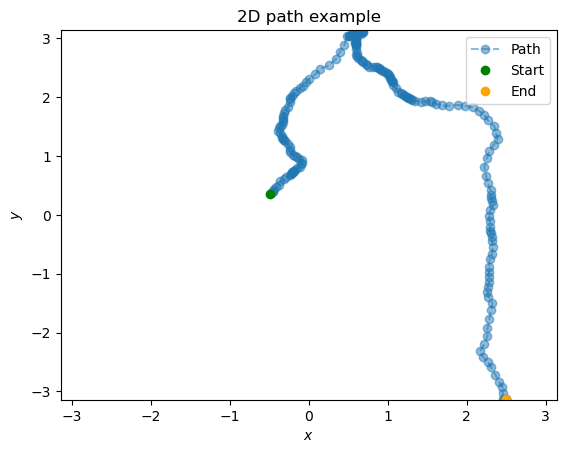

In [4]:
path = labels.cpu().detach().numpy()

# path = np.array(labels)

# Unsqeeze to add a batch dimension
# path = np.expand_dims(path, axis=0)
print(path.shape)

n = 0
p0 = data[n,0,:].cpu().detach().numpy()
plt.plot(path[n,:,0], path[n,:,1], '--o',alpha=0.5)
# # Plot first
# plt.plot(path[n,0,0],path[n,0,1],"o",color="green")
plt.plot(p0[0],p0[1],"o",color="green")
# # Plot last
plt.plot(path[n,-1,0],path[n,-1,1],"o",color="orange")
plt.title("2D path example")
plt.xlim(-np.pi,np.pi)
plt.ylim(-np.pi,np.pi)
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend(["Path","Start","End"])
plt.show()

In [5]:
# # Generate dataset and save in ../datasets
# # First generate gradual gradual dataset

def train_gradual_gen(epochs,batch_size=64,per=15):
    i = 0
    training_steps = 1
    gen_data = []
    for epoch in tqdm(range(epochs)):
        # data,labels = smooth_wandering_2D_squarefix(batch_size,training_steps,bound=0.5,v_sigma=0.01,d_sigma=0.08,v_bound_reduction=0.15,stability=0.0)
        # data,labels = smooth_wandering_2D_squarefix_randomstart_hdv(batch_size,training_steps,bound=0.5,v_sigma=0.02,d_sigma=0.08,v_bound_reduction=0.15,stability=0.0)
        # data,labels = smooth_wandering_2D_squarefix_randomstart_hdv_vrng(batch_size,training_steps,bound=0.5,v_sigma_mean=0.01,d_sigma=0.08,v_bound_reduction=0.15,stability=0.0)
        # data, labels = rat_box_v2(batch_size,training_steps,hdv=True)
        data, labels = smooth_wandering_2D_ratinabox(batch_size,training_steps)
        # data,labels = smooth_wandering_2D_squarefix_hdv(batch_size,training_steps,bound=0.5,v_sigma=0.01,d_sigma=0.08,v_bound_reduction=0.15,stability=0.0)
        # data,labels = smooth_wandering_2D_squarefix(test_batch_size,t_test)
        # data,labels = rat_box(batch_size,training_steps)
        gen_data.append((data.cpu().detach(),labels.cpu().detach()))
        i+=1
        if i%per == 0:
            training_steps += 1
    print("Last training time steps:",training_steps)
    return gen_data
    # Save dataset

@torch.compile
def train_constant(epochs,batch_size=64,training_steps=200):
    gen_data = []
    for epoch in tqdm(range(epochs)):
        # data,labels = smooth_wandering_2D_squarefix(batch_size,training_steps,bound=0.5,v_sigma=0.01,d_sigma=0.1,v_bound_reduction=0.15,stability=0.01)
        # data,labels = smooth_wandering_2D_squarefix_randomstart_hdv(batch_size,training_steps,bound=0.5,v_sigma=0.01,d_sigma=0.08,v_bound_reduction=0.15,stability=0.0)
        # data,labels = smooth_wandering_2D_squarefix_randomstart_hdv_vrng(batch_size,training_steps,bound=0.5,v_sigma_mean=0.01,d_sigma=0.08,v_bound_reduction=0.15,stability=0.0)
        # data, labels = rat_box_v2(batch_size,training_steps,hdv=True)
        data, labels = smooth_wandering_2D_ratinabox(batch_size,training_steps)
        # data,labels = smooth_wandering_2D_squarefix(test_batch_size,t_test)
        # data,labels = rat_box(batch_size,training_steps)
        gen_data.append((data.cpu().detach(),labels.cpu().detach()))
    print("Last training time steps:",training_steps)
    return gen_data

batch_size = 256
per = 25
epochs = 5000
t_steps = 40
# gen_data = train_gradual_gen(epochs,batch_size=batch_size,per=per)
gen_data = train_constant(epochs,batch_size=batch_size,training_steps=t_steps)
# np.save("../datasets/gradual_2D_ratinabox_{}_{}_{}".format(epochs,per,batch_size),gen_data) # Will be saved as [Epochs,data/labels,batchsize,tsteps,x/y]
np.save("../datasets/constant_2D_ratinaboxnew_{}_{}_{}".format(epochs,t_steps,batch_size),gen_data) # Will be saved as [Epochs,data/labels,batchsize,tsteps,x/y]


100%|██████████| 5000/5000 [20:53<00:00,  3.99it/s]
/home/users/mattisdo/.pyenv/versions/3.10.12/envs/env/lib/python3.10/site-packages/numpy/lib/npyio.py:528: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.asanyarray(arr)
/home/users/mattisdo/.pyenv/versions/3.10.12/envs/env/lib/python3.10/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating 

Last training time steps: 40


In [ ]:
class Datamodel(Dataset):
    def __init__(self,time_pos_points,labels):
        self.x = time_pos_points
        self.y = labels
    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]
    
data = input_data[:,0]
labels = input_data[:,1]
datamodel = Datamodel(data, labels)
data_loader = DataLoader(datamodel, batch_size=1, shuffle=False, num_workers=1)

In [ ]:
batch_size = 10
training_steps = 200

# data,labels = smooth_wandering_2D_squarefix_randomstart_hdv(batch_size,training_steps,bound=0.5,v_sigma=0.02,d_sigma=0.08,v_bound_reduction=0.15,stability=0.0)
data,labels = smooth_wandering_2D_ratinabox(batch_size,training_steps)
# data,labels = rat_box_v2(batch_size,training_steps)

In [ ]:
data[:,1:,0,:].max()

tensor(6.2822, device='cuda:0')

(100, 10, 2)


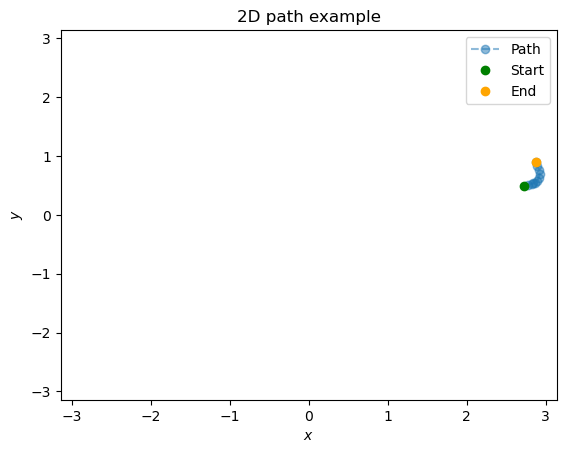

In [ ]:
from scipy import stats as stats

def ornstein_uhlenbeck(dt, x, drift=0.0, noise_scale=0.2, coherence_time=5.0):
    # From Ratinabox Github
    """An ornstein uhlenbeck process in x.
    x can be multidimensional
    Args:
        dt: update time step
        x: the stochastic variable being updated
        drift (float, or same type as x, optional): [description]. Defaults to 0.
        noise_scale (float, or same type as x, optional): Magnitude of deviations from drift. Defaults to 0.2 (20 cm s^-1 if units of x are in metres).
        coherence_time (float, optional):
        Effectively over what time scale you expect x to change. Can be a vector (one timescale for each element of x) directions. Defaults to 5.

    Returns:
        dx (same type as x); the required update to x
    """
    x = torch.Tensor(x)
    drift = drift * torch.ones_like(x)
    noise_scale = noise_scale * torch.ones_like(x)
    coherence_time = coherence_time * torch.ones_like(x)
    sigma = torch.sqrt((2 * noise_scale**2) / (coherence_time * dt))
    theta = 1 / coherence_time
    dx = theta * (drift - x) * dt + sigma * torch.randn(x.shape)*dt
    return dx

def normal_to_rayleigh(x, sigma=1):
    """Converts a normally distributed variable (mean 0, var 1) to a rayleigh distributed variable (sigma)"""
    x = torch.tensor(stats.norm.cdf(x.cpu()))  # norm to uniform
    x = sigma * torch.sqrt(-2 * torch.log(1 - x))  # uniform to rayleigh
    return x

def rayleigh_to_normal(x, sigma=1):
    """Converts a rayleigh distributed variable (sigma) to a normally distributed variable (mean 0, var 1)"""
    x = 1 - torch.exp(-(x**2) / (2 * sigma**2))  # rayleigh to uniform
    x = torch.clamp(x, min=1e-6, max=1 - 1e-6)
    x = torch.tensor(stats.norm.ppf(x.cpu()))  # uniform to normal
    return x

In [ ]:
def smooth_wandering_2D_ratinabox(n_data,t_steps,v_sigma=0.08,v_coherence=0.7,d_sigma=120 * (np.pi / 180),d_coherence=0.08,d_scaler=10,v_bound_reduction=0.15,dt=0.01):
    bound = 0.5
    v_mean = 0.08
    speed_coherence = v_coherence
    direction_pert_coherence = d_coherence
    direction_pert_std=  d_sigma
    # Save head direction and speed in data
    data = torch.zeros((n_data, t_steps+1, 2))
    # Save position in x and y direction in labels
    labels = torch.zeros((n_data, t_steps, 2))
    start_positions = torch.rand(n_data,2)*2*bound-bound
    data[:,0,:] = start_positions
    
    # Draw start directions such that they are not pointing towards the boundry
    # Where start positions is in for example first quadrant, draw start directions in between pi and 3pi/2
    directions = torch.rand(n_data)
    # start_directions = start_directions.unsqueeze(1)
    speeds = v_mean*torch.ones(n_data)
    direction_perts = torch.zeros(n_data) # = start rotational speeds
    for t in tqdm(range(t_steps)):
        direction_perts_new = ornstein_uhlenbeck(dt,direction_perts,drift=0,noise_scale=direction_pert_std,coherence_time=direction_pert_coherence)
        if torch.any(speeds==0):  # add tiny velocity in [1,0] direction to avoid nans
            speeds[speeds==0] = 1e-8
        normal_variable = rayleigh_to_normal(speeds, sigma=v_mean)
        new_normal_variable = normal_variable + ornstein_uhlenbeck(dt=dt,x=normal_variable,drift=0,noise_scale=1,coherence_time=speed_coherence)
        new_speeds = normal_to_rayleigh(new_normal_variable, sigma=v_mean)
        directions_new = directions + direction_perts_new*d_scaler*dt
        directions_new = torch.remainder(directions_new,2*np.pi)
        data[:,t+1,0] = directions_new
        data[:,t+1,1] = new_speeds
        if t == 0:
            labels[:,t,0] = start_positions[:,0] + new_speeds*torch.cos(directions_new)
            labels[:,t,1] = start_positions[:,1] + new_speeds*torch.sin(directions_new)
        else:
            labels[:,t,0] = labels[:,t-1,0] + new_speeds*torch.cos(directions_new)
            labels[:,t,1] = labels[:,t-1,1] + new_speeds*torch.sin(directions_new)
        bound_mask = (labels[:,t,0] > bound) | (labels[:,t,0] < -bound) | (labels[:,t,1] > bound) | (labels[:,t,1] < -bound)
        while bound_mask.any():
            # If any of the positions are outside the bound, redraw the velocities and directions for those trajectories
            direction_perts_new[bound_mask] = torch.Tensor(np.random.choice([-1,1],int(bound_mask.sum()))).to(device)*(torch.randn((int(bound_mask.sum()),))*0.5 + np.pi/2)
            if torch.any(speeds[bound_mask]==0):  # add tiny velocity in [1,0] direction to avoid nans
                speeds[bound_mask][speeds[bound_mask]==0] = 1e-8
            normal_variable = rayleigh_to_normal(speeds[bound_mask], sigma=v_mean)
            new_normal_variable = normal_variable + ornstein_uhlenbeck(dt=dt,x=normal_variable,drift=0,noise_scale=1,coherence_time=speed_coherence)
            new_speeds[bound_mask] = normal_to_rayleigh(new_normal_variable, sigma=v_mean)*v_bound_reduction
            directions_new[bound_mask] = directions[bound_mask] + direction_perts_new[bound_mask]
            directions_new[bound_mask] = torch.remainder(directions_new[bound_mask],2*np.pi)
            
            data[bound_mask,t+1,0] = directions_new[bound_mask]
            data[bound_mask,t+1,1] = new_speeds[bound_mask].float()
            if t == 0:
                labels[bound_mask,t,0] = (start_positions[bound_mask,0] + new_speeds[bound_mask]*torch.cos(directions_new[bound_mask])).float()
                labels[bound_mask,t,1] = (start_positions[bound_mask,1] + new_speeds[bound_mask]*torch.sin(directions_new[bound_mask])).float()
            else:
                labels[bound_mask,t,0] = (labels[bound_mask,t-1,0] + new_speeds[bound_mask]*torch.cos(directions_new[bound_mask])).float()
                labels[bound_mask,t,1] = (labels[bound_mask,t-1,1] + new_speeds[bound_mask]*torch.sin(directions_new[bound_mask])).float()
            bound_mask = (labels[:,t,0] > bound) | (labels[:,t,0] < -bound) | (labels[:,t,1] > bound) | (labels[:,t,1] < -bound)
        speeds = new_speeds
        directions = directions_new
        direction_perts = direction_perts_new
        

    data = data.unsqueeze(-1)
    # labels = labels.unsqueeze(-1)
    # Scale by 2pi to be in range -pi to pi
    data[:,0,:,:] = data[:,0,:,:]*2*np.pi/(2*bound)
    data[:,1:,1,:] = data[:,1:,1,:] * 2*np.pi/(2*bound)
    labels = labels*2*np.pi/(2*bound)
    return data, labels

        